In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

### Stuff from class to work with

In [2]:
def rng(m=2**32, a=1103515245, c=12345):
    rng.current = (a * rng.current + c) % m
    return rng.current / m

# setting the seed
rng.current = 1

In [3]:
def rng_bad(m=2**31, a=65539, c=0):
    rng_bad.current = (a * rng_bad.current + c) % m
    return rng_bad.current / m
rng_bad.current = 1

random = [rng_bad() for _ in range(10000)]

In [4]:
samples = [rng() for _ in range(10000)]

### Problem 1
Implement serial test and apply to a `samples`

In [5]:
def serial_test(samples, k=10, dims=2, no_error=False):
  if not no_error:
    assert len(samples)%dims == 0, f"Array cant be broken into series of length {dims}"
  if no_error:
    samples_ = samples[:len(samples)-len(samples)%dims]
  temp = np.array(samples_).reshape(-1,dims)
  n = len(temp) #num of numbers
  exp = np.full([k for i in range(dims)], n/(k**dims))
  real = np.histogramdd(temp, [np.linspace(0, 1, k+1) for i in range(dims)])[0]
  return exp, real, stats.chisquare(real.flatten(), exp.flatten())

For 1 dimenstions p-value is  0.9825553875075259
For 2 dimenstions p-value is  0.7895660152477539
For 3 dimenstions p-value is  0.37755820732038237
For 4 dimenstions p-value is  0.01134913063418066
For 5 dimenstions p-value is  0.32612394025764035


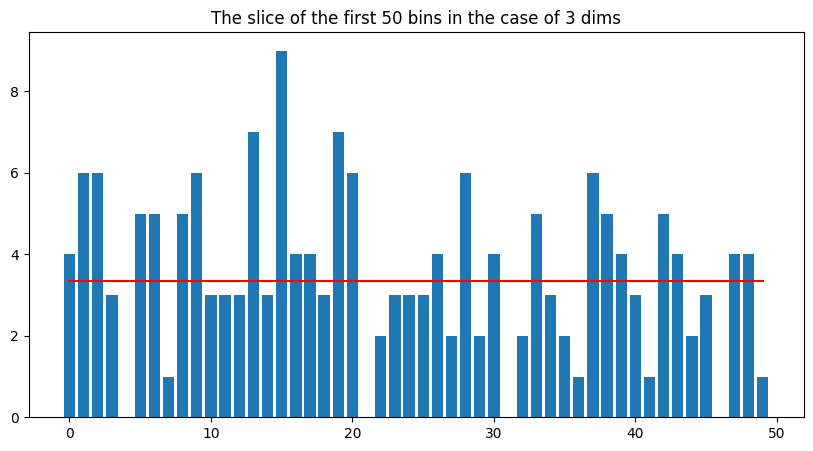

In [6]:
for dim in range(1,6):
  print(f"For {dim} dimenstions p-value is ", serial_test(samples, dims=dim, no_error=True)[2][1])

test_3 = serial_test(samples, dims=3, no_error=True)
plt.figure(figsize=(10,5))
plt.title("The slice of the first 50 bins in the case of 3 dims")
plt.bar(range(50), test_3[1].flatten()[0:50])
plt.plot(range(50), test_3[0].flatten()[0:50], color = "red")
plt.show()

We again decompose the sequence $x_1, x_2, x_3, ..., x_{dn}$ into consecutive series of length $d$: $(x_1, ..., x_d), (x_{d+1}, x_{2d+d}), \ldots, (x_{nd-d+1}, x_{nd})$. A series of $d$ elements can be ordered in $d!$ ways and each way of ordering is equally probable. Hence the idea of the test is to count how many times each ordering occurs among $n$ series and apply the $\chi^2$ test.

### Problem 2*
Implement permutation test and apply to a `samples`

In [7]:
from math import factorial
def permutational_test(samples, d):
    if len(samples)%d != 0:
        samples_ = samples[0:len(samples) - len(samples)%d]
    else: samples_ = samples
    #Make masks of args order to count them later
    temp = np.array(samples_).reshape(-1, d)
    mask = temp.argsort(axis = 1)
    count = dict()
    #Counting the orders frequencies
    for row in mask:
        if tuple(row) in count:
            count[tuple(row)] += 1
        else: count[tuple(row)] = 1
    #Apply test
    real = np.array(list(count.values()))
    if (real.shape[0] < factorial(d)):
        real = np.concatenate([real, np.zeros(factorial(d)-real.shape[0])], axis=0)
    return stats.chisquare(real, np.full(factorial(d), temp.shape[0]/factorial(d)))

In [8]:
permutational_test(samples[:1000],10)[1]

0.5145586770430779

### Problem 3

Provide a statistical test to show that `rng_bad` has problems but `rng_good` does not.

The bad one p-value  5.420245454658504e-69
The good one p-value  0.9930403504104895
The slice of the first 50 bins


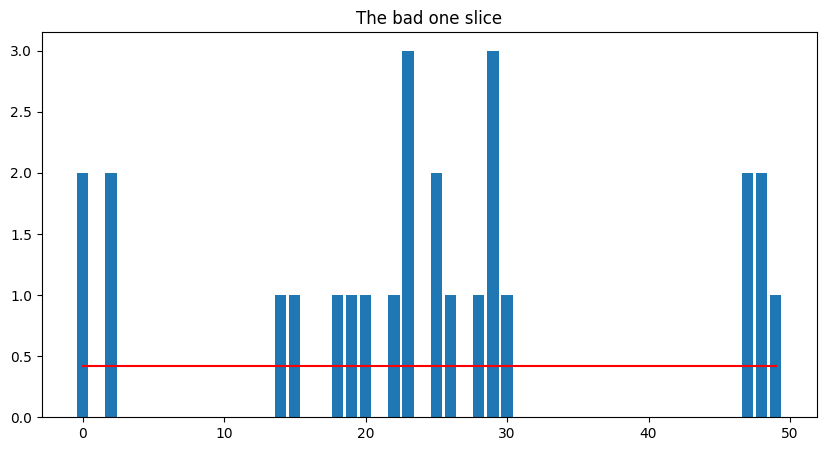

In [9]:
test_3 = serial_test(random, k = 20, dims=3, no_error=True)

plt.figure(figsize=(10,5))
plt.bar(range(50), test_3[1].flatten()[0:50])
plt.plot(range(50), test_3[0].flatten()[0:50], color = "red")
plt.title("The bad one slice")

print("The bad one p-value ", test_3[2][1]) #The p-value is close to 0

print("The good one p-value ", serial_test(samples, k = 20, dims=3, no_error=True)[2][1])
print("The slice of the first 50 bins")

plt.show()

### Problem 4
Simulate a sample of 1000 from a discrete distribution on a set of digits $0, 1, 2, \ldots, 9$ with weights $0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2$. Construct a histogram from the sample. Optimise the algorithm by ordering the weights.

In [11]:
digits = np.array(range(0,10))
weights = np.array([0.12, 0.3, 0.167, 0.24, 0.31, 0.54, 0.111, 0.02, 0.001, 0.2])
c = weights.sum()
weights = weights/c #Norm the weights
k = 3000

mask = weights.argsort() #Sort weights
digits = digits[mask] 
weights = weights[mask]

field = weights.cumsum() #Make the cumulative sum of the weights to use mask to sample later
sample = np.random.rand(k)

sample = digits[(field.reshape(1,10) - sample.reshape(k,1) < 0).argmin(axis=1)]

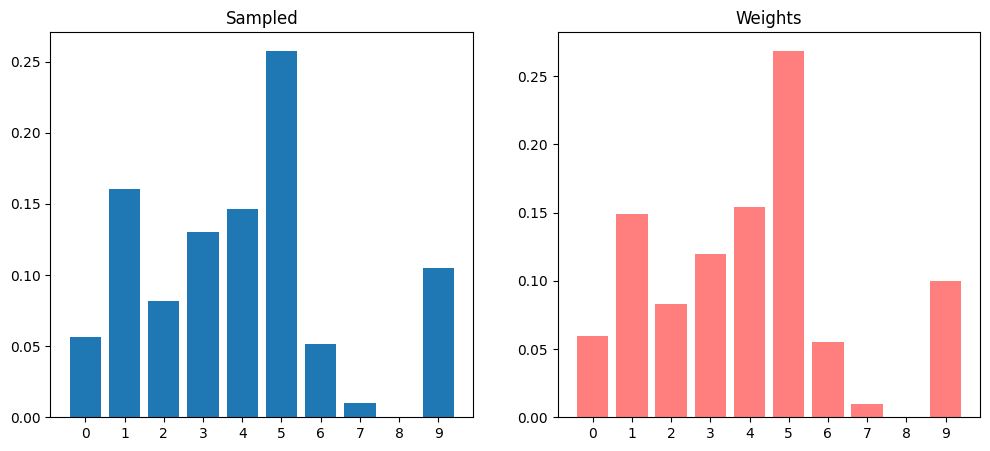

In [12]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].bar(digits, np.histogram(sample, range(0,11))[0][mask]/len(sample))
ax[0].set_title("Sampled")
ax[0].set_xticks(range(0,10))

ax[1].bar(digits, weights, alpha=0.5, color="red")
ax[1].set_title("Weights")
ax[1].set_xticks(range(0,10))

plt.show()

### Problem 5
Simulate a sample of size 1000 from the distribution $\operatorname{Exp}(\lambda)$ using the Inverse transform method. Construct a sample histogram and an accurate plot of the distribution density.

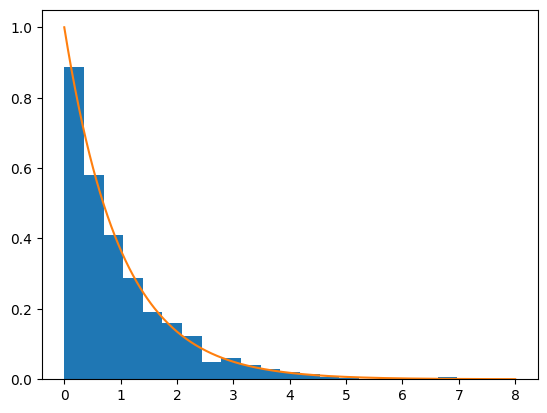

In [13]:
#We need 1-e^(-x) as F
#F^-1 = -Ln(1-x)
sample = np.random.rand(1000)
sample = -np.log((1-sample))
plt.hist(sample, density=True, bins=20)
plt.plot(np.linspace(0,8,500), np.exp(-np.linspace(0,8,500)))
plt.show()

### Problem 6 
Justify (orally) that the accept-reject method really samples from the required distribution. Simulate $1000$ points from the distribution with density $e^xcos^2x \cdot \mathbb{I}_{[-\frac\pi2, \frac\pi2]}$. Plot the sampled histogram on the sample and compare it with the plot of the exact density function.

### Stuff from class to work with

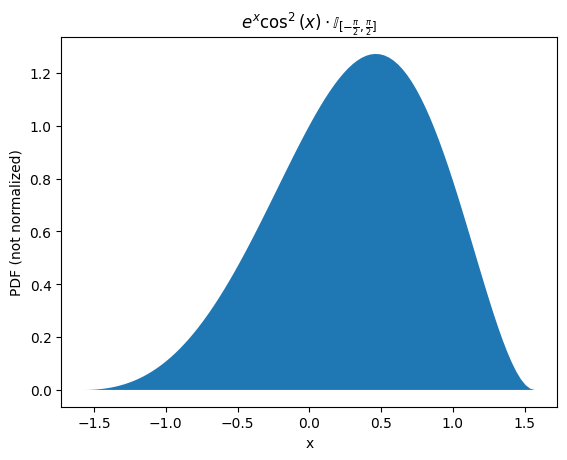

In [16]:
fig = plt.figure()
x = np.linspace(-np.pi/2, np.pi/2, 100)
density = np.exp(x) * np.cos(x) ** 2 # not normalized density!
plt.fill_between(x, 0, density)
plt.ylabel('PDF (not normalized)')
plt.xlabel('x')
plt.title(r'$e^x \cos^2(x) \cdot \mathbb{I}_{[-\frac{\pi}{2}, \frac{\pi}{2}]}$')

plt.show()

### Problem 6 (solution)

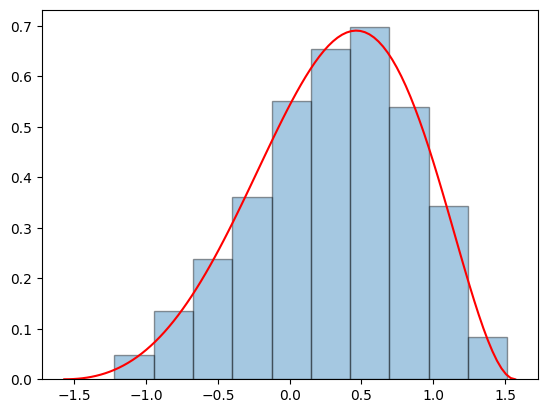

In [159]:
density_norm = density/np.trapz(density, x)

c = 1/density.max()/np.pi
sample_1 = (np.random.rand(5000) - 0.5)*np.pi
sample_2 = np.random.rand(5000)/np.pi
sample = sample_1[sample_2 <= c * np.exp(sample_1) * (np.cos(sample_1) ** 2)]
sample = sample[0:1000]

plt.hist(sample, bins=10, alpha=0.4, density=True, edgecolor="black")
plt.plot(x, density_norm, color="red")
plt.show()

### Problem 7
Model and depict a sample of 500 points uniformly distributed within a given triangle without using a selection method.

### Stuff from class to work with

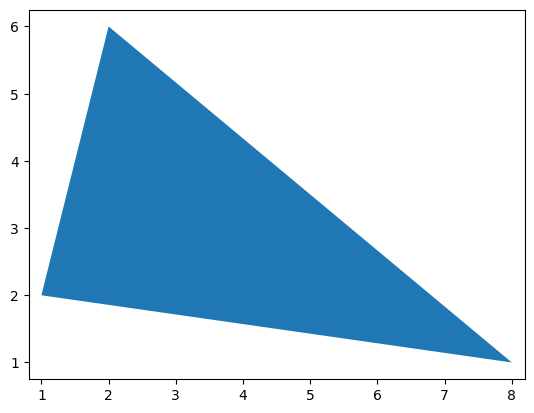

In [85]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

fig = plt.figure()

polygon = Polygon(xy=np.array([[1, 2], [2, 6], [8, 1]]), closed=True)
plt.gca().add_collection(PatchCollection([polygon]))
plt.axis('equal')
plt.show()

### Problem 7 (solution)

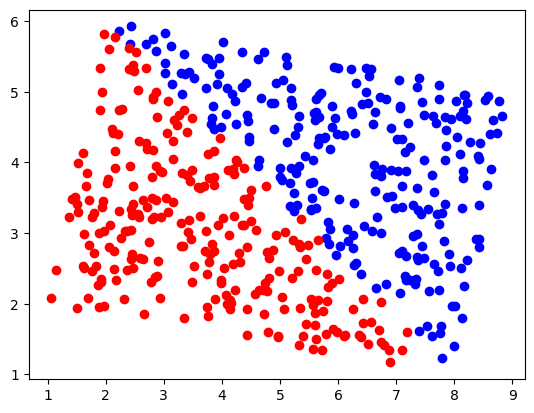

In [162]:
#Lets use some analytic geometry
C = np.array([[7,1],
              [-1,4]])
B = np.array([1,2]).reshape(2,1)
sample = np.random.rand(2,500)
res = C@sample + B
res = res.transpose()
#The equation of the line btw (2,6) and (8,1) is F(x,y) = 5x+6y-46=0
#I am going to make rotation for the points that are F(point) > 0
points_to_rotate = res[res[:,0]*5+6*res[:,1]-46>0]
points_to_save = res[res[:,0]*5+6*res[:,1]-46<=0]
plt.scatter(points_to_rotate[:,0], points_to_rotate[:,1],color="blue")
plt.scatter(points_to_save[:,0], points_to_save[:,1], color="red")
plt.show()

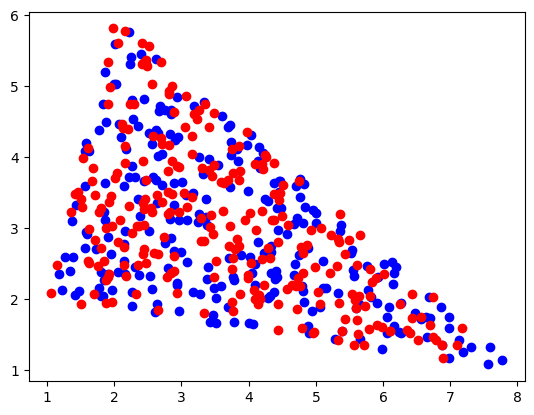

In [163]:
B = np.array([2+3,6-2.5]).reshape(2,1)
points_to_rotate = points_to_rotate.transpose()
points_to_rotate = points_to_rotate - B
points_to_rotate = np.array([[-1,0],[0,-1]])@points_to_rotate #We are rotating the blue triangle 
points_to_rotate = points_to_rotate + B
points_to_rotate = points_to_rotate.transpose()
plt.scatter(points_to_rotate[:,0], points_to_rotate[:,1],color="blue")
plt.scatter(points_to_save[:,0], points_to_save[:,1], color="red")

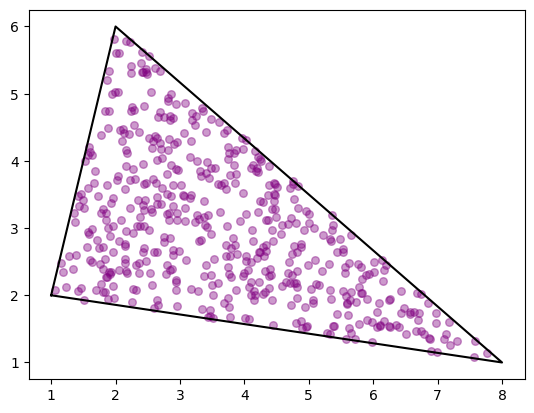

In [164]:
sample = np.concatenate([points_to_rotate, points_to_save], axis = 0)
plt.scatter(sample[:,0],sample[:,1], alpha=0.4, color = "purple", s=30)
plt.plot([1,2,8,1], [2,6,1,2], color="black")
plt.show()

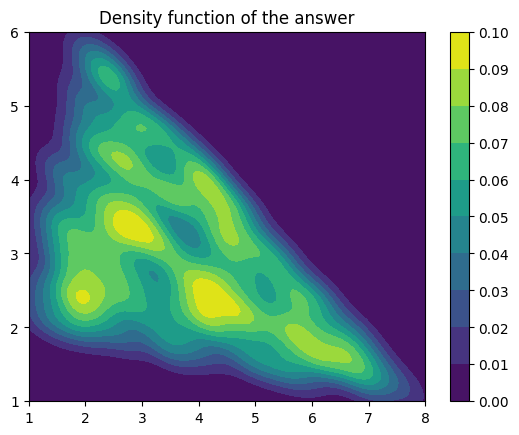

In [165]:
x, y = sample[:,0], sample[:,1]
kde = stats.gaussian_kde(np.concatenate([x.reshape(-1,1),y.reshape(-1,1)], axis = 1).transpose(), 0.2)

n = 100
xx, yy = np.meshgrid(np.linspace(1,8,n), np.linspace(1,6,n))
zz = np.array([[kde.pdf([xx[i,j], yy[i,j]])[0] for j in range(0,n)] for i in range(0,n)])
plt.contourf(xx, yy, zz, levels=10)
bar = plt.colorbar()
bar.set_ticks(np.linspace(0, bar.get_ticks()[-1], 11))
plt.title("Density function of the answer")
plt.show()

### Problem 8
Model without using the selection method a sample of $500$ points uniformly distributed inside the unit circle. Picture the obtained points. Do they really fill the circle uniformly?

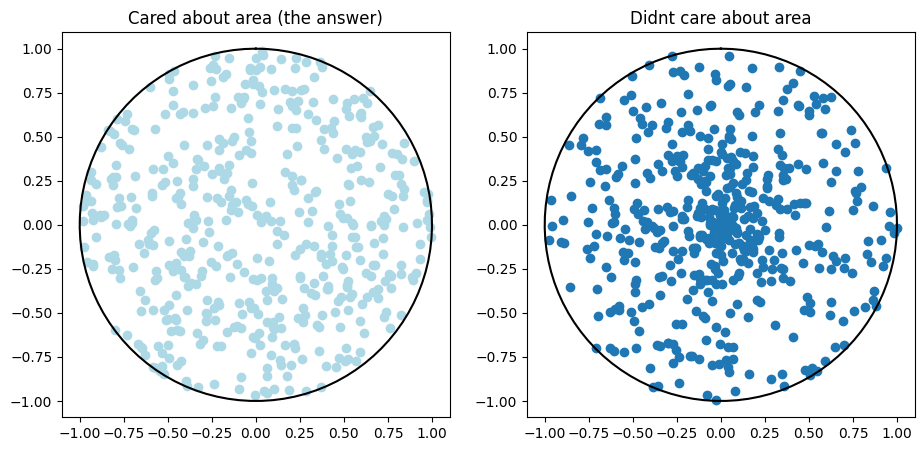

In [5]:
#x = cos(phi)*r
#y = sin(phi)*r

# A = [[-sin(phi)*r, cos(phi)]
#      [co(phi)*r, sin(phi)]]
#|det(A)| = r
#f(x,y) = g(phi,r)/r
#so we need to take g(phi,r) = r*c
#g(phi,r) = r/pi
#lets firstly sample r*c
#we will use F = r**2*c
#F^-1 = sqrt(r/c)
def gen(n=500): #generator
    #Making needed distribution
    phi = np.random.rand(n,1)*2*np.pi
    r = np.random.rand(n,1)
    
    sample = np.concatenate([phi,r], axis=1)
    sample[:,1] = sample[:,1]**0.5
    
    x = np.cos(sample[:,0])*sample[:,1]
    y = np.sin(sample[:,0])*sample[:,1]
    return x,y
    
x, y = gen()

#for comparison
phi = np.random.rand(500,1)*2*np.pi
r = np.random.rand(500,1)

#Ploting the result
fig, ax = plt.subplots(1,2, figsize=(11,5))
ax[0].scatter(x,y, color = "lightblue")
ax[0].axis("equal")
ax[1].scatter(np.cos(phi)*r, np.sin(phi)*r)
ax[1].set_title("Didnt care about area")
ax[0].set_title("Cared about area (the answer)")
t = np.linspace(0, 2*np.pi, 100)
ax[0].plot(np.sin(t), np.cos(t), color ="black")
ax[1].plot(np.sin(t), np.cos(t), color ="black")
ax[1].axis("equal")

plt.show()

### Proof of uniformity

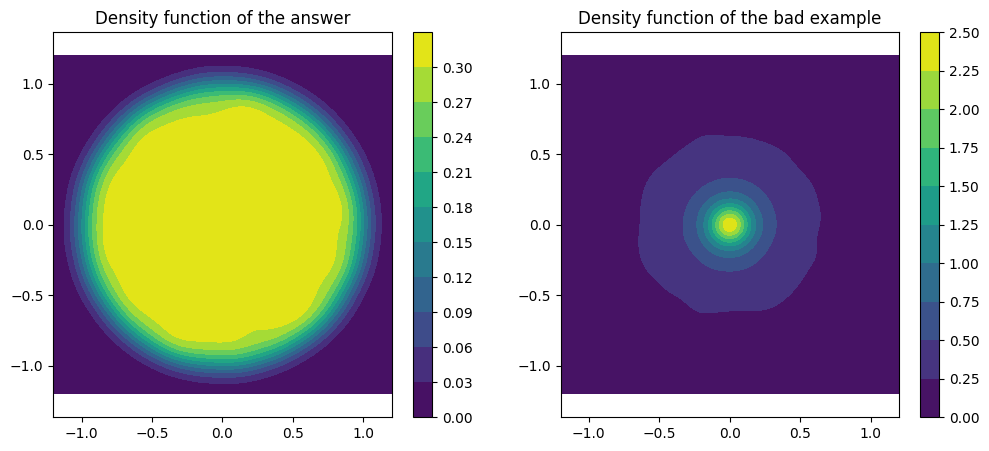

In [569]:
#I have written the formula that proofs the fact of uniform kind of the ditribution, but will make practical proof
#Going to find density via KDE
plt.figure(figsize=(12,5))

x,y=gen(100000)
kde = stats.gaussian_kde(np.concatenate([x.reshape(-1,1),y.reshape(-1,1)], axis = 1).transpose(), 0.2)

n = 100
xx, yy = np.meshgrid(np.linspace(-1.2,1.2,n), np.linspace(-1.2,1.2,n))
zz = np.array([[kde.pdf([xx[i,j], yy[i,j]])[0] for j in range(0,n)] for i in range(0,n)])
plt.subplot(121)
plt.contourf(xx, yy, zz, levels=10)
plt.title("Density function of the answer")
plt.axis("equal")
bar = plt.colorbar()
bar.set_ticks(np.linspace(0, bar.get_ticks()[-1], 11))

phi = np.random.uniform(0,2*np.pi,(100000,1))
r = np.random.uniform(0,1,(100000,1))
x,y = np.cos(phi)*r, np.sin(phi)*r
kde = stats.gaussian_kde(np.concatenate([x.reshape(-1,1),y.reshape(-1,1)], axis = 1).transpose(), 0.2)

xx, yy = np.meshgrid(np.linspace(-1.2,1.2,n), np.linspace(-1.2,1.2,n))
zz = np.array([[kde.pdf([xx[i,j], yy[i,j]])[0] for j in range(0,n)] for i in range(0,n)])
plt.subplot(122)
plt.contourf(xx, yy, zz, levels=10)
plt.title("Density function of the bad example")
plt.axis("equal")
bar = plt.colorbar()
bar.set_ticks(np.linspace(0, bar.get_ticks()[-1], 11))

plt.show()

So, yes, I assume this distribution is uniform

# Random normal 

### Problem 9
Prove (orally) that the following algorithm (**Box-Muller algorithm**, https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform) generates a sample of independent $\mathcal{N}(0,1)$ random variables. Modify the method to exclude calls of trigonometric functions `np.sin` and `np.cos`. Using the modified method, simulate a sample size of $1000$ from a $2D$ Gaussian distribution with mean $\mu$ and covariance matrix $\Sigma$, where
$$\mu = \begin{pmatrix} 4 \\ 7 \end{pmatrix}^T, \quad \Sigma = \begin{pmatrix} 20 & -4 \\ -4 & 40 \end{pmatrix}.$$
Construct a 2D histogram of the resulting distribution. Compare the sample mean and covariance matrix with the exact values.

### Stuff from class to work with

In [2]:
import seaborn as sns

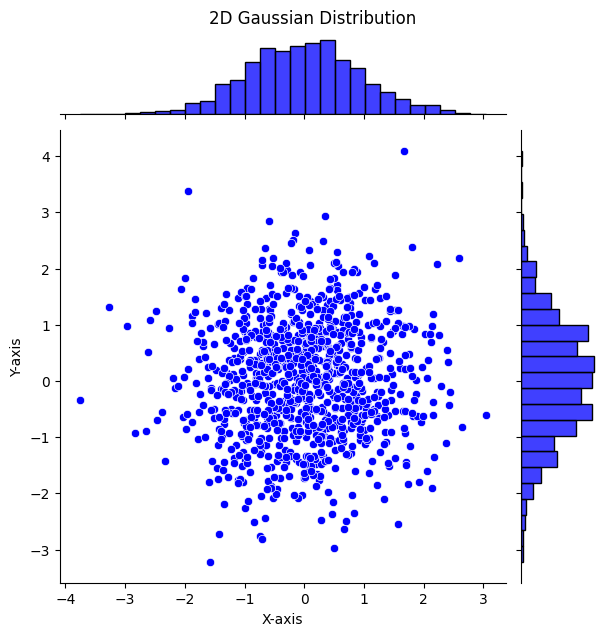

In [3]:
n = 1000
u1, u2 = np.random.rand(2, n)
r = np.sqrt(-2 * np.log(u1))
theta = 2 * np.pi * u2
x = r * np.cos(theta)
y = r * np.sin(theta)


joint_plot = sns.jointplot(x=x, y=y, color="blue")
joint_plot.set_axis_labels('X-axis', 'Y-axis')
plt.suptitle('2D Gaussian Distribution', y=1.02)
plt.show()

### Problem 9 (solution)

In [101]:
n = 1000
#First of all we need to sample points of the circule
x,y = gen(n) #I can use accept-reject method to sample it
#but I already have generator (it uses sin and cos, but i have a function for it, 
#                              lets suppose that got uniform dist without using sin and cos)

#Now we will use formulas (use characteristic function to check, that they are independent normally distributed variables)
#u = x*sqrt(-2ln(x^2+y^2)/(x^2+y^2))
#v = y*sqrt(-2ln(x^2+y^2)/(x^2+y^2))

u, v = x*(-2*np.log(x**2+y**2)/(x**2+y**2))**0.5, y*(-2*np.log(x**2+y**2)/(x**2+y**2))**0.5

corr coef: 0.00044072228445880834


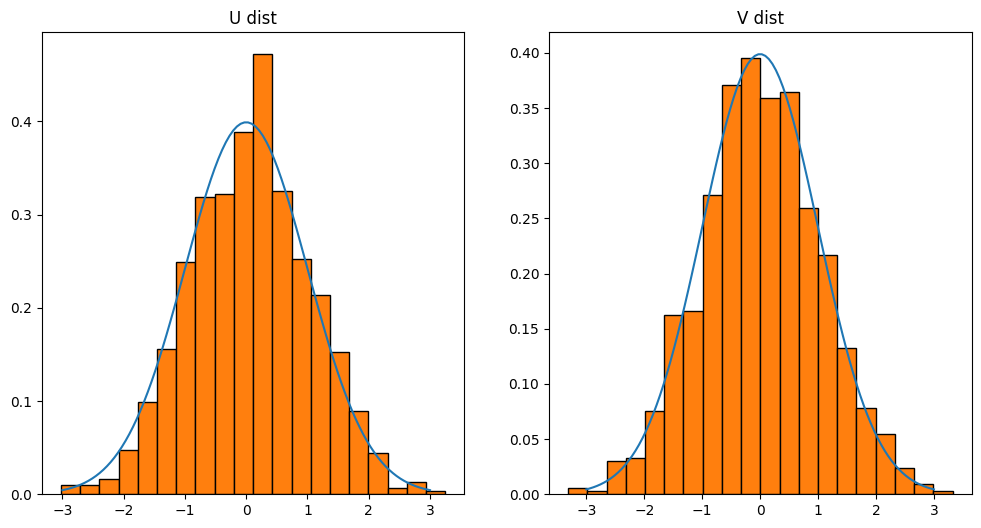

In [102]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(np.linspace(-3,3,100), np.exp(-np.linspace(-3,3,100)**2/2) * 1/(2*np.pi)**0.5)
plt.hist(u, bins = 20, density=True, edgecolor="black")
plt.title("U dist")
plt.subplot(122)
plt.plot(np.linspace(-3,3,100), np.exp(-np.linspace(-3,3,100)**2/2) * 1/(2*np.pi)**0.5)
plt.hist(v, bins = 20, density=True, edgecolor="black")
plt.title("V dist")
print(f"corr coef: {np.corrcoef(u,v)[0,1]}")
plt.show()

In [103]:
# New corr matrix B of (u,v) = A*(x,y)
# B = A^t*A
A = np.linalg.cholesky(np.array([[20,-4],[-4,20]])).transpose()
u_, v_ =A @[u,v] + np.array([4,7]).reshape(2,1)

In [104]:
print("Cov matrix: \n", np.corrcoef(u_,v_)*np.array([[u_.std()*v_.std(),u_.std()*v_.std()],
                                                     [u_.std()*v_.std(),v_.std()*v_.std()]]))
print("Means:", u_.mean(), v_.mean())

Cov matrix: 
 [[19.92782764 -4.12252128]
 [-4.12252128 20.2382424 ]]
Means: 4.281440215194671 7.0892745843316005


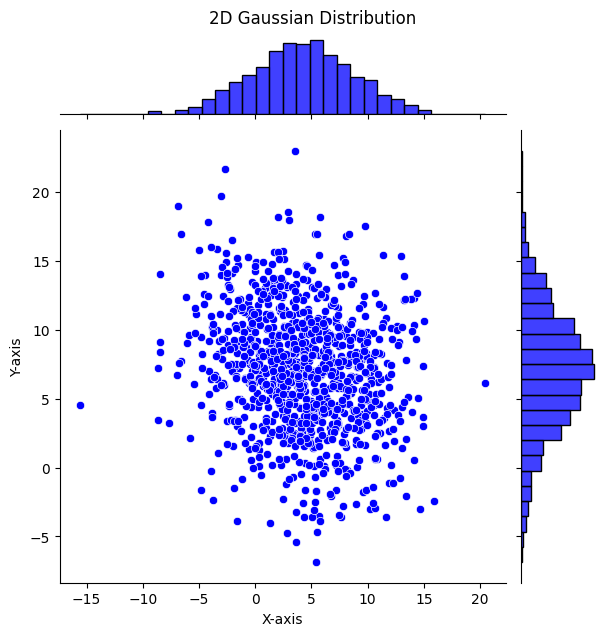

In [92]:
joint_plot = sns.jointplot(x=u_, y=v_, color="blue")
joint_plot.set_axis_labels('X-axis', 'Y-axis')
plt.suptitle('2D Gaussian Distribution', y=1.02)
plt.show()

### Problem 10*

Implement a method of generating a random partition of an n-element set into subsets. Use it to estimate the expected number of subsets in a random partition of a set of 100 elements.

Hint 1: Ширяев, Вероятность, т1, задача 2 к параграфу 1.

Hint 2: http://djalil.chafai.net/blog/2012/05/03/generating-uniform-random-partitions/

In [82]:
from scipy.special import binom 

#Calculating Bells num
def calc_B(n):
    arr = [1,1,2]
    if n  <= 2:
        return arr[n]
    else: 
        for i in range(3,n+1):
            arr.append(sum( [binom(i-1,j)*arr[j] for j in range(i)] ))
    return arr[-1]

#Calculating K according to the formula p(K=k) = k^n/(e*k!B_n)
def sample_K(n, B_n = None):
    if B_n == None:
        B = calc_B(n)
    else: B = B_n 
    val = np.random.rand(1)
    cumsum = 0
    i = 0
    while True:
        cumsum += i**n/B/np.e/factorial(i)
        if val < cumsum:
            return i
        else: i += 1

#Sampling Cn uniformly on {1,...,K}
def generate_C_arr(n, B_n=None):
    K = sample_K(n, B_n)
    C_arr = list(map(int, np.random.rand(n)*K+1))
    return C_arr

#The function to generate uniformly partition
def get_partition(arr, B_n=None):
    n = len(arr)
    C_arr = generate_C_arr(n, B_n)
    partition = dict()
    for i, c in enumerate(C_arr):
        if c in partition:
            partition[c].append(arr[i])
        else: partition[c] = [arr[i]]
    return list(partition.values())

print("Examples for partitions of [1,2,3,4,5] \n")
print(get_partition([1,2,3,4,5]))
print(get_partition([1,2,3,4,5]))
print(get_partition([1,2,3,4,5]))
print(get_partition([1,2,3,4,5]))
print(get_partition([1,2,3,4,5]))

Examples for partitions of [1,2,3,4,5] 

[[1], [2, 3], [4, 5]]
[[1, 5], [2, 3, 4]]
[[1, 3, 4, 5], [2]]
[[1, 2], [3, 4], [5]]
[[1, 3], [2], [4], [5]]


In [85]:
#Calculating the expected number of subsets in a random partition of a set of 100 elements
temp = 0
n = 1000
for i in range(n):
    temp += np.unique(generate_C_arr(100, calc_B(100))).shape[0]
print("the expected number of subsets in a random partition of a set of 100 elements:", temp/n)

the expected number of subsets in a random partition of a set of 100 elements: 28.714
